In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
from glob import glob
from PIL import Image

In [2]:
import os

# The standard path to your "My Drive" contents
my_drive_path = '/kaggle/input/chest-xray/'
# The path to your dataset via the shortcut
# Replace 'large_image_dataset' with the actual name of the folder/shortcut
dataset_path = os.path.join(my_drive_path, 'chest_xray')

# Let's verify we can see the contents
print(f"Accessing dataset at: {dataset_path}")
try:
    # List the first 5 items in the folder to confirm access
    contents = os.listdir(dataset_path)
    print("Successfully accessed the folder. Contents:")
    print(contents[:5])
except FileNotFoundError:
    print("Error: Could not find the dataset folder.")
    print("Please check two things:")
    print("1. Did you create the shortcut in your 'My Drive'?")
    print("2. Is the folder/shortcut name spelled correctly in the 'dataset_path' variable?")

Accessing dataset at: /kaggle/input/chest-xray/chest_xray
Successfully accessed the folder. Contents:
['val', 'test', 'train']


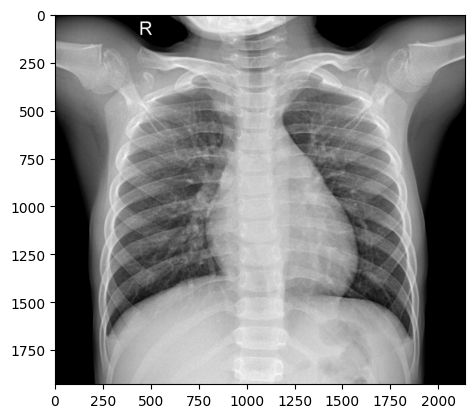

In [3]:
plt.imshow(Image.open("/kaggle/input/chest-xray/chest_xray/train/NORMAL/IM-0143-0001.jpeg"), cmap="gray")
plt.show()

In [4]:
img = Image.open("/kaggle/input/chest-xray/chest_xray/train/NORMAL/IM-0143-0001.jpeg")
img_array = np.array(img)
img_array.shape

(1928, 2138)

In [5]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       #transforms.RandomCrop(224),
                                       #transforms.RandomRotation(15),
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.ColorJitter(brightness=0.1, contrast=0.1),
                                       transforms.GaussianBlur(kernel_size=3),
                                       transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
                                       #transforms.Grayscale(num_output_channels=1), # Add this line to convert to grayscale
                                       transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)), # Rotates +/- 15 degrees, shifts by +/- 10%
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                       ])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      #transforms.Grayscale(num_output_channels=1), # Add this line to convert to grayscale
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      ])

In [6]:
train_dataset = datasets.ImageFolder(
    root = "/kaggle/input/chest-xray/chest_xray/train",
    transform = train_transforms
)

test_dataset = datasets.ImageFolder(
    root = "/kaggle/input/chest-xray/chest_xray/test",
    transform = test_transforms
)

In [7]:
train_files = glob("/kaggle/input/chest-xray/chest_xray/train/*/*")
test_files = glob("/kaggle/input/chest-xray/chest_xray/test/*/*")

In [8]:
len(train_files), len(test_files)

(2624, 228)

In [9]:
train_class_nor= glob("/kaggle/input/chest-xray/chest_xray/train/NORMAL/*")
train_class_par= glob("/kaggle/input/chest-xray/chest_xray/train/PNEUMONIA/*")

In [10]:
len(train_class_nor), len(train_class_par)

(84, 2540)

In [11]:
# targets = np.array(train_dataset.targets)
# from torch.utils.data import WeightedRandomSampler
# class_sample_count = np.array([len(np.where(targets==t)[0]) for t in np.unique(targets)])
# weights = 1. / class_sample_count
# samples_weight = weights[targets]

# sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [12]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle= True,
                                           num_workers=3,
                                           pin_memory=True
                                           )

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [13]:
model = models.densenet201(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 158MB/s]


In [14]:
for params in model.parameters():
  params.requires_grad = False

In [15]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [16]:
model.classifier

Linear(in_features=1920, out_features=1000, bias=True)

In [17]:
model.classifier = nn.Sequential(
    nn.Linear(1920, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5), # Add dropout with a 50% probability
    nn.Linear(256, 2)
    )
#print(model)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [19]:
# Your class counts: {'NORMAL': 84, 'PNEUMONIA': 2540}
# PyTorch's ImageFolder will likely assign classes alphabetically: NORMAL=0, PNEUMONIA=1
# Check dset['train'].class_to_idx to be sure

# Calculate weights: 1 / (number of samples)
# The weight for the smaller class will be much larger
# weights = torch.tensor([1.0/84, 1.0/2540], dtype=torch.float32)
# weights = weights/weights.sum()
weights = torch.tensor([45, 1], dtype=torch.float32)
print(weights)

# from sklearn.utils.class_weight import compute_class_weight
# weights2 = compute_class_weight('balanced', classes=np.unique(train_dataset.targets), y=train_dataset.targets)
# weights2 = torch.tensor(weights2, dtype=torch.float32)
# print(weights2)

# Send weights to the same device as your model (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = weights.to(device)


tensor([45.,  1.])


In [20]:
from torch.optim.lr_scheduler import OneCycleLR
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr= 3e-4, weight_decay=1e-4)

schedular = OneCycleLR(optimizer, max_lr=3e-4, steps_per_epoch=len(train_loader), epochs=5, pct_start=0.1)

In [21]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)


            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            # schedular.step() # Move this outside the batch loop
            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)

        model.eval()
        test_loss = []
        with torch.no_grad():
          for inputs, targets in test_loader:
              inputs, targets = inputs.to(device), targets.to(device)

              outputs = model(inputs)
              loss = criterion(outputs, targets)
              test_loss.append(loss.item())
          test_loss = np.mean(test_loss)
          model.train()

        train_losses[it] = train_loss
        test_losses[it] = test_loss
        schedular.step() # Step the scheduler once per epoch

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')

    return train_losses, test_losses

In [22]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, 20)

Epoch 1/20, Train Loss: 0.6686, Test Loss: 0.6103, Duration: 0:00:38.145081
Epoch 2/20, Train Loss: 0.6411, Test Loss: 0.5910, Duration: 0:00:33.702334
Epoch 3/20, Train Loss: 0.6020, Test Loss: 0.5937, Duration: 0:00:33.645883
Epoch 4/20, Train Loss: 0.5806, Test Loss: 0.5779, Duration: 0:00:32.898802
Epoch 5/20, Train Loss: 0.5510, Test Loss: 0.5821, Duration: 0:00:34.043351
Epoch 6/20, Train Loss: 0.5089, Test Loss: 0.5563, Duration: 0:00:33.016687
Epoch 7/20, Train Loss: 0.4749, Test Loss: 0.5360, Duration: 0:00:34.821533
Epoch 8/20, Train Loss: 0.4261, Test Loss: 0.4985, Duration: 0:00:34.113552
Epoch 9/20, Train Loss: 0.3721, Test Loss: 0.4879, Duration: 0:00:34.143202
Epoch 10/20, Train Loss: 0.3273, Test Loss: 0.4610, Duration: 0:00:35.342048
Epoch 11/20, Train Loss: 0.2808, Test Loss: 0.4331, Duration: 0:00:34.225983
Epoch 12/20, Train Loss: 0.2428, Test Loss: 0.4365, Duration: 0:00:33.330711
Epoch 13/20, Train Loss: 0.2180, Test Loss: 0.3886, Duration: 0:00:33.099794
Epoch 14

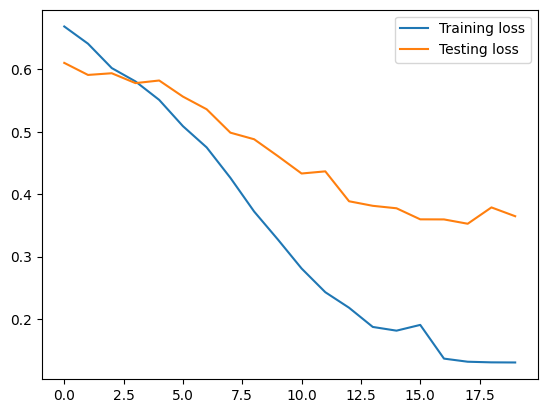

In [23]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend()
plt.show()

In [24]:
def get_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return 100 * correct / total

train_accuracy = get_accuracy(train_loader)
test_accuracy = get_accuracy(test_loader)

print(f"Train accuracy: {train_accuracy:.4f}%")
print(f"Test accuracy: {test_accuracy:.4f}%")


Train accuracy: 94.8933%
Test accuracy: 77.1930%


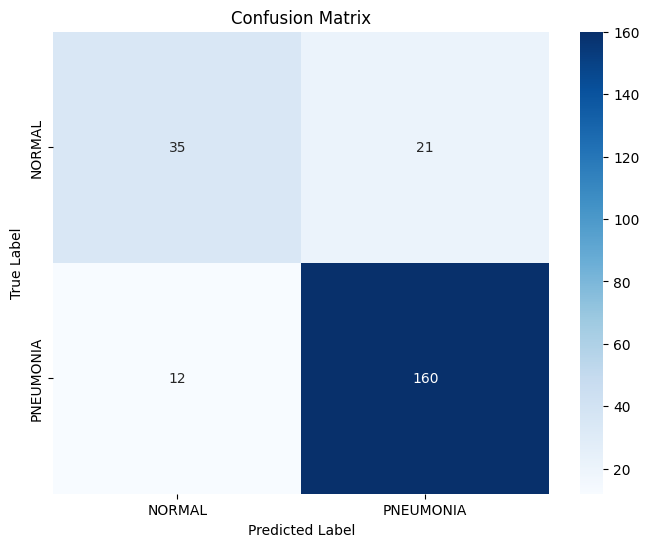

In [25]:
# prompt: generate confusion matrix

from sklearn.metrics import confusion_matrix,precision_recall_curve
import seaborn as sns


def get_all_preds_and_labels(model, loader, device):
    """
    Runs the model on the entire dataset and returns all probabilities and true labels.
    """
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            # Get probabilities for the PNEUMONIA class (class 1)
            probabilities = torch.softmax(logits, dim=1)[:, 1]
            
            all_preds.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return np.array(all_preds), np.array(all_labels)

# --- Run this on your test set ---
# (Note: In a real project, you'd find the threshold on a validation set first)
y_scores, y_true = get_all_preds_and_labels(model, test_loader, device)
# Ensure the model is in evaluation mode
model.eval()

# Collect all true labels and predicted labels
all_targets = []
all_predicted = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_targets.extend(targets.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_targets, all_predicted)

# Get class names from the dataset (assuming it's an ImageFolder)
class_names = test_dataset.classes

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# prompt: function to print the four evaluation parameters and the F1 score 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_evaluation_metrics(true_labels, predicted_labels):
  """
  Calculates and prints Accuracy, Precision, Recall, and F1 Score.

  Args:
    true_labels (list or array): The true labels.
    predicted_labels (list or array): The predicted labels.
  """
  accuracy = accuracy_score(true_labels, predicted_labels)
  precision = precision_score(true_labels, predicted_labels, average='binary') # Use 'binary' for binary classification
  recall = recall_score(true_labels, predicted_labels, average='binary')     # Use 'binary' for binary classification
  f1 = f1_score(true_labels, predicted_labels, average='binary')           # Use 'binary' for binary classification

  print(f"Accuracy: {accuracy *100:.4f} %")
  print(f"Precision: {precision*100:.4f} %")
  print(f"Recall: {recall*100:.4f} %")
  print(f"F1 Score: {f1*100:.4f} %")

# Assuming you have already collected all_targets and all_predicted
# after running the confusion matrix code
print("\nEvaluation Metrics:")
print_evaluation_metrics(all_targets, all_predicted)



Evaluation Metrics:
Accuracy: 85.5263 %
Precision: 88.3978 %
Recall: 93.0233 %
F1 Score: 90.6516 %


In [27]:
# The path can be .pth, .pt, or .bin
SAVE_PATH = 'pneumonia_classifier_weights.pth'

torch.save(model.state_dict(), SAVE_PATH)

print(f"✅ Model weights saved successfully to {SAVE_PATH}")

✅ Model weights saved successfully to pneumonia_classifier_weights.pth


In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# --- 2. Load your saved weights ---
# This is the file you created in the last step
model_path = 'pneumonia_classifier_weights.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
print(f"✅ Model loaded from {model_path} and ready for visualization.")

✅ Model loaded from pneumonia_classifier_weights.pth and ready for visualization.


In [29]:
target_layer = model.features.denseblock4

In [30]:
import cv2
from PIL import Image
import torch.nn.functional as F

# --- Helper function to un-normalize and display a tensor image ---
def denormalize_and_show(tensor_img):
    """
    Denormalizes a tensor image using ImageNet stats and converts it for display.
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor_img = tensor_img.clone().cpu()
    for t, m, s in zip(tensor_img, mean, std):
        t.mul_(s).add_(m)
    img = tensor_img.numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)
    return img

In [31]:
def generate_grad_cam(model, input_tensor, target_layer, target_class=None):
    """
    Generates a Grad-CAM heatmap.
    Temporarily unfreezes the target layer to guarantee gradient flow.
    """
    activations = dict()
    original_grad_states = {}
    for name, param in target_layer.named_parameters():
        original_grad_states[name] = param.requires_grad
        param.requires_grad = True # Temporarily unfreeze

    def save_activation(module, input, output):
        activations['feature_map'] = output.detach()

    def save_gradient(module, grad_in, grad_out):
        activations['gradient'] = grad_out[0].detach()

    handle_forward = target_layer.register_forward_hook(save_activation)
    handle_backward = target_layer.register_full_backward_hook(save_gradient)

    try:
        model.eval()
        logits = model(input_tensor)
        if target_class is None:
            target_class = logits.argmax(dim=1).item()
        one_hot = torch.zeros_like(logits)
        one_hot[0][target_class] = 1
        model.zero_grad()
        logits.backward(gradient=one_hot, retain_graph=True)
    finally:
        # CRITICAL: Restore original requires_grad states to not affect training
        handle_forward.remove()
        handle_backward.remove()
        for name, param in target_layer.named_parameters():
            param.requires_grad = original_grad_states[name]

    if 'gradient' not in activations or 'feature_map' not in activations:
        print("Error: Failed to capture gradients or feature maps.")
        return None

    feature_maps = activations['feature_map']
    gradients = activations['gradient']
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    feature_maps = feature_maps.squeeze(0)
    for i in range(feature_maps.shape[0]):
        feature_maps[i, :, :] *= pooled_gradients[i]
    heatmap = torch.mean(feature_maps, dim=0).squeeze()
    heatmap = F.relu(heatmap)
    if torch.max(heatmap) > 0:
        heatmap /= torch.max(heatmap)
    return heatmap.cpu().numpy()

In [32]:
def plot_predictions_with_cam(model, loader, class_names, device, target_layer, num_images=2):
    """
    Plots model predictions with original images and Grad-CAM overlays.
    This updated version shows random samples from the loader each time it's run.
    """
    model.eval()
    
    # --- THIS IS THE NEW PART ---
    # To get random samples, we create a new DataLoader with shuffle=True
    # using the same dataset as the original loader.
    vis_loader = torch.utils.data.DataLoader(loader.dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(vis_loader))
    # --- END OF NEW PART ---
    
    images, labels = images.to(device), labels.to(device)

    # Get model predictions
    with torch.no_grad():
        logits = model(images)
        predicted_classes = logits.argmax(dim=1)

    # Plot the images and their CAMs
    plt.figure(figsize=(15, num_images * 3.5))
    for i in range(num_images):
        image_for_cam = images[i].unsqueeze(0)
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_classes[i]]
        
        original_img_to_plot = denormalize_and_show(images[i])
        
        # Generate CAM for the model's PREDICTED class
        cam = generate_grad_cam(model, image_for_cam, target_layer, target_class=predicted_classes[i].item())
        
        if cam is not None:
            # Create heatmap overlay
            heatmap = cv2.resize(cam, (original_img_to_plot.shape[1], original_img_to_plot.shape[0]))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            
            superimposed_img = heatmap * 0.4 + original_img_to_plot * 255
            superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

            # Subplot 1: Original Image with Labels
            plt.subplot(num_images, 2, 2*i + 1)
            plt.imshow(original_img_to_plot)
            plt.axis('off')
            title_color = 'green' if true_label == pred_label else 'red'
            plt.title(f"True: {true_label}\nPredicted: {pred_label}", color=title_color)

            # Subplot 2: Image with CAM Overlay
            plt.subplot(num_images, 2, 2*i + 2)
            plt.imshow(superimposed_img)
            plt.axis('off')
            plt.title(f"CAM for Prediction: {pred_label}")
    
    plt.tight_layout()
    plt.show()


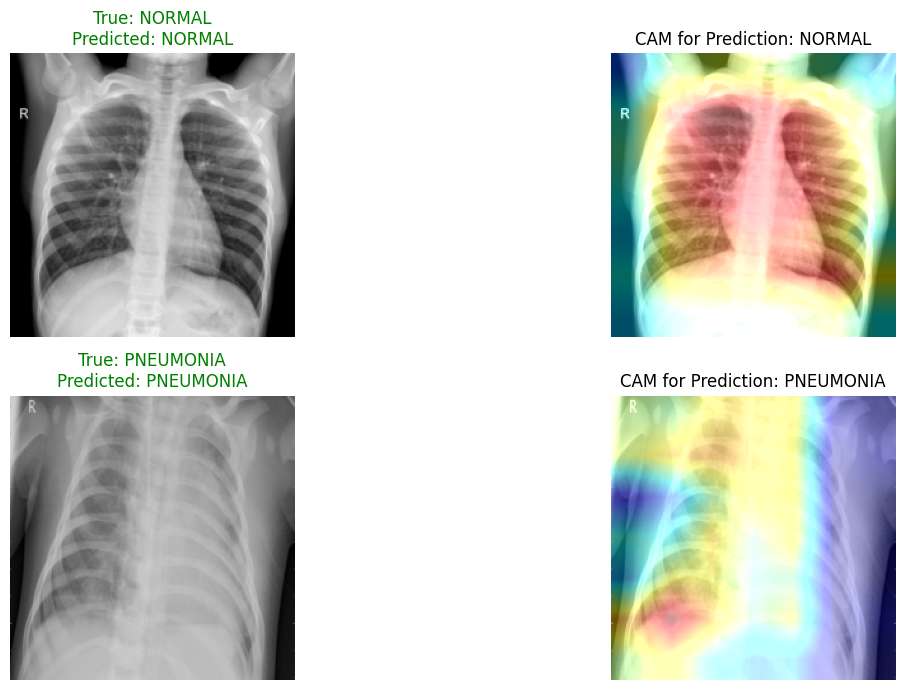

In [33]:
# The final cell from your notebook (this part is correct)
class_names = test_dataset.classes
target_layer = model.features.denseblock4 # This is the correct target for densenet201
inference_transform = test_transforms

# Call the master plotting function
plot_predictions_with_cam(model, test_loader, class_names, device, target_layer, num_images=2)

In [34]:
def predict_and_visualize(model, image_path, transform, class_names, device, target_layer, threshold=0.75):
    """
    Loads an image, makes a prediction using a custom threshold, and displays
    the image with its CAM overlay.
    """
    # 1. Load and preprocess the image
    pil_image = Image.open(image_path).convert("RGB")
    input_tensor = transform(pil_image).unsqueeze(0).to(device)

    # 2. Get model predictions
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        probabilities = torch.softmax(logits, dim=1)
    
    # Get the probability for the "PNEUMONIA" class (assuming it's class 1)
    p_pneumonia = probabilities[0, 1].item()

    # 3. Apply the custom threshold to decide the label
    if p_pneumonia >= threshold:
        predicted_class_idx = 1 # PNEUMONIA
        confidence = p_pneumonia
    else:
        predicted_class_idx = 0 # NORMAL
        confidence = 1 - p_pneumonia
        
    predicted_label = class_names[predicted_class_idx]

    # 4. Generate CAM for the predicted class
    cam = generate_grad_cam(model, input_tensor, target_layer, target_class=predicted_class_idx)
    
    # 5. Prepare images for plotting
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    superimposed_img = None
    if cam is not None:
        heatmap = cv2.resize(cam, (original_img.shape[1], original_img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        superimposed_img = heatmap * 0.4 + original_img
        superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # 6. Plot the results side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    #fig.suptitle(f"Prediction using Threshold = {threshold:.2f}", fontsize=16)

    # Plot original image
    axs[0].imshow(original_img)
    axs[0].axis('off')
    axs[0].set_title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2%}")

    # Plot CAM overlay
    if superimposed_img is not None:
        axs[1].imshow(superimposed_img)
        axs[1].axis('off')
        axs[1].set_title(f"CAM for '{predicted_label}' Prediction")
    else:
        axs[1].text(0.5, 0.5, 'CAM Generation Failed', ha='center', va='center')
        axs[1].axis('off')

    plt.tight_layout()
    plt.show()

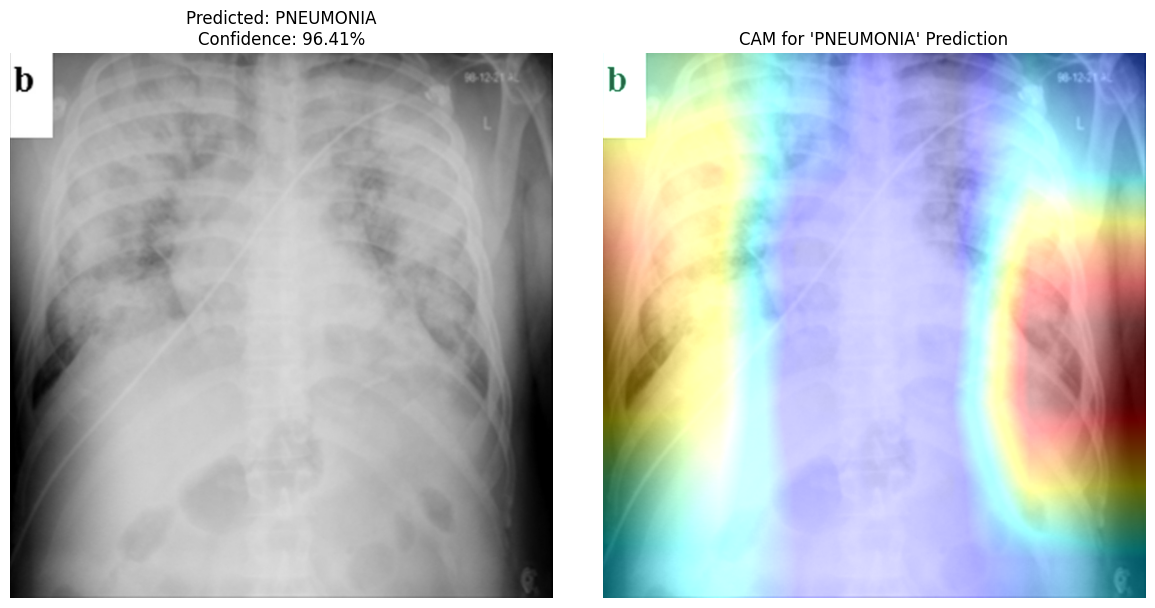

In [35]:
predict_and_visualize(
    model=model,
    image_path="/kaggle/input/chest-xray/chest_xray/val/PNEUMONIA/COVID19(34).jpg",
    transform=inference_transform,
    class_names=class_names,
    device=device,
    target_layer=target_layer,
)